In [1]:
# imports
from numpy.fft import fft, fftshift, fftfreq
from collections import Counter, deque

import matplotlib.pyplot as plt
import numpy as np
import subprocess
import warnings
import librosa
import math
import os

warnings.filterwarnings(
    "ignore",
    message="PySoundFile failed"
)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning
)

In [2]:
def extractSongInfo(filename: str) -> list[str]:
    """
        Splits filename up into useful info
    """
    info = filename.split("_")
    info = [x.replace("-", " ").lower() for x in info]
    
    if len(info) == 4:
        artist, song, key, bpm = info
        bpm = bpm[:-4]
    else:
        artist, song, key, bpm, _ = info

    item = (artist, song, key, bpm)
    
    return item

### Divide songs by key

In [3]:
# read in audio data and store in a dictionary
major_songs = []
minor_songs = []
audio_data = {}

folder = "songs"

for file in os.listdir(os.path.join(folder)):
    if file[0] != ".":
        
        item = extractSongInfo(file)
        _, _, key, _ = item
        
        # librosa does not work well with .mp3 files
        audio, sample_rate = librosa.load(os.path.join(os.getcwd(), folder, file))
        
        # get length of audio file
        command = "ffprobe -v error -show_entries format=duration -of default=noprint_wrappers=1:nokey=1 "
        command += f"{os.path.join(os.getcwd(), folder, file)}"
        
        length = subprocess.run(
            command.split(),
            stdout=subprocess.PIPE
        )
        
        # truncate to 2 decimals
        numSeconds = float(length.stdout)
        numSeconds = "{:.{}f}".format(numSeconds, 2)
        
        # hashes audio data
        audio_data.update({
            '_'.join(item) : (audio, float(numSeconds))
        })
        
        # store song based on quality of key
        if key.find("major") != -1:
            major_songs.append(item)
        else:
            minor_songs.append(item)

major_songs.sort(key=lambda x: x[2])
minor_songs.sort(key=lambda x: x[2])

print(len(major_songs), len(minor_songs))
print(len(audio_data))

65 35
100


In [4]:
# read in instrumental data and store in a dictionary
instrumental_data = {}

folder = "instrumentals"

for file in os.listdir(os.path.join(folder)):
    if file[0] != ".":
        
        item = extractSongInfo(file)
        artist, song, key, bpm = item
        
        info = (artist, song, key, bpm)
        
        # librosa does not work well with .mp3 files
        audio, sample_rate = librosa.load(os.path.join(os.getcwd(), folder, file))
        
        # get length of audio file
        command = "ffprobe -v error -show_entries format=duration -of default=noprint_wrappers=1:nokey=1 "
        command += f"{os.path.join(os.getcwd(), folder, file)}"
        
        length = subprocess.run(
            command.split(),
            stdout=subprocess.PIPE
        )
        
        # truncate to 2 decimals
        numSeconds = float(length.stdout)
        numSeconds = "{:.{}f}".format(numSeconds, 2)
        
        # hashes audio data
        instrumental_data.update({
            '_'.join(info) : (audio, float(numSeconds))
        })
        
print(len(instrumental_data))

100


## Get Song to Test

bee gees_how deep is your love_f minor_105
Samples per second: 22049.913544668587
Song is 260.25 long


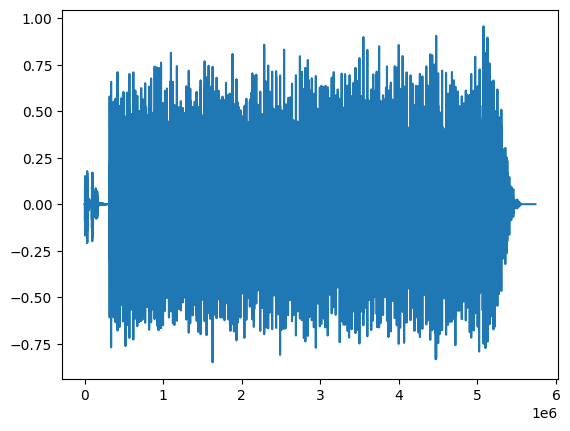

In [154]:
# test data reads

ind = list(instrumental_data.keys())[0]
samples, seconds = instrumental_data[ind]

print(ind)
print("Samples per second:", (int(samples.shape[0]))/seconds)
print(f"Song is {seconds} long")
plt.plot(samples)
plt.show()

## Planning: How to Get Key of Song from Data

Idea 1: divide song into multiple overlapping chunks and perform FFT on all of them \
>       0:00 |--------|   |--------|   |--------| 4:23
                   |--------|   |--------|
                   
        - make length of window a function of bpm and length of song

In [6]:
# get average bpm
avg_bpm = 0
for song in audio_data:
    _, _, _, bpm = song.split("_")
    avg_bpm += int(bpm)
    
avg_bpm /= len(audio_data)
print(f"Average BPM: {avg_bpm}")

Average BPM: 119.01


In [7]:
# get minimum song length
min_song_length = 2**16
for _, secs in audio_data.values():
    min_song_length = min(min_song_length, secs)
print(f"Minimum song length: {min_song_length}")

Minimum song length: 135.0


In [8]:
# get average length (in seconds)
avg_song_secs = 0
avg_instr_secs = 0

for _, secs in audio_data.values():
    avg_song_secs += secs
for _, secs in instrumental_data.values():
    avg_instr_secs += secs
    
avg_song_secs /= len(audio_data)
avg_instr_secs /= len(audio_data)

avg_song_secs = round(avg_song_secs, 2)
avg_instr_secs = round(avg_instr_secs, 2)
print(f"Average Song Length:\t\t{avg_song_secs} seconds")
print(f"Average Instrumental Length:\t{avg_instr_secs} seconds")

Average Song Length:		237.62 seconds
Average Instrumental Length:	248.6 seconds


In [9]:
# prints avg song length in minutes and seconds
print(avg_instr_secs//60, avg_instr_secs%60)

4.0 8.599999999999994


In [10]:
"""
    For each window to contain 16 bars,
    seconds_per_beat = (1/bpm)*(60)
    window_width = 16*4*seconds_per_beat
    
    plan for 4 max modulations
"""
sixteen_bars = round(16*4*(60/avg_bpm), 2)
print(f"Seconds in 16 bars: {sixteen_bars}")


Seconds in 16 bars: 32.27


In [6]:
def get_window_length(song_len: float) -> int:
    """
        Clamps window length between 15 and 45 seconds
        15 seconds for songs <= 2:, 45 seconds for songs >= 6 mins
        
        :return: window length in seconds
    """
    song_len = min(max(song_len, 15*8), 45*8)
    return int(song_len//8)

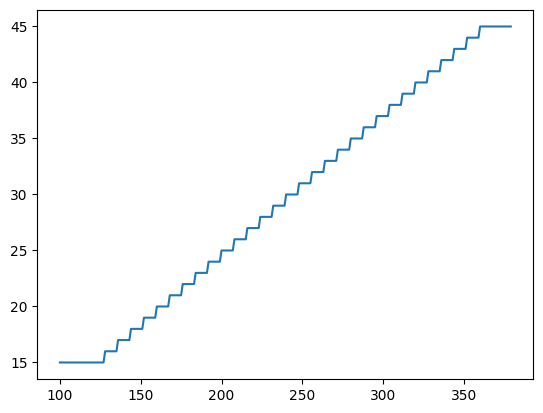

In [7]:
# test get_window_length(...)
x = [i for i in range(100, 380)]
y = [get_window_length(i) for i in x]
plt.plot(x, y)
plt.show()

In [7]:
def get_samp_per_sec(song_len: float, num_samples: int) -> float:
    """
        Returns number of samples per second
        
        May not be in use any longer
    """
    if isinstance(num_samples, tuple):
        num_samples = num_samples[0]
    samp_per_sec = num_samples/song_len
    return samp_per_sec

In [86]:
print("Samples per second:", get_samp_per_sec(seconds, samples.shape))

Samples per second: 22049.605805411215


In [185]:
def create_snippets(song: list[float], song_len: float) -> list[list[float]]:
    """
        Creates 2D numpy array of form:
            snippets[num_snippet][sample_index_in_snippet]
            
        Windows/snippets overlap at midpoint
        
        :song: raw audio data
        :song_len: length of the song in seconds
        
        :return snippets: list of windows of samples
                         each sample has format:
                         (seconds since start, audio data)
        :return start_times: list of start_times of each
                             window in seconds past since
                             song start
                 
    """
    snippets = np.array([])
    start_times = np.array([])
    
    mult = int(get_samp_per_sec(song_len, song.shape[0])) # try replacing with 44100
    win_len = mult*get_window_length(song_len)
    
    win_start = 0
    while win_start < song.shape[0]:
        part = song[win_start:win_start + win_len]
        if part.shape[0] < win_len:
            part = np.pad(part, (0, win_len - part.shape[0]))
            
        start_times = np.append(start_times, win_start/mult)
        snippets = np.vstack((snippets, part)) if snippets.size else part
        win_start += win_len//2
        
    return snippets, start_times

In [109]:
# get windows from song
windows, start_times = create_snippets(samples, seconds)

Window Shape: (9, 1190700)


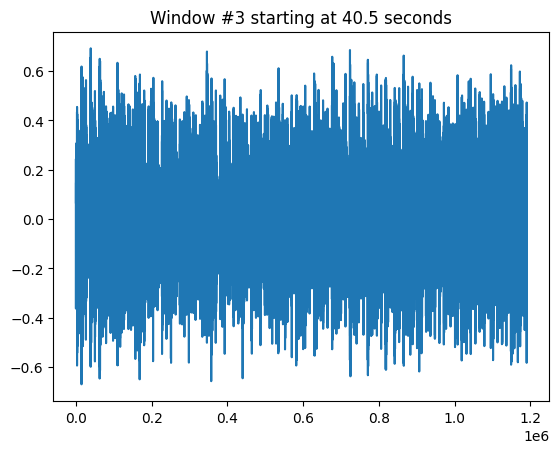

In [110]:
win_num = 3

print("Window Shape:", windows.shape)

plt.plot(windows[win_num])
plt.title(f"Window #{win_num} starting at {start_times[win_num]} seconds")
plt.show()
plt.close()

## Goal: Obtain most prevalent frequencies in a window and find closest

### FFT Testing

[ 27. 300.  10.]
[ 27. 300.  10.]


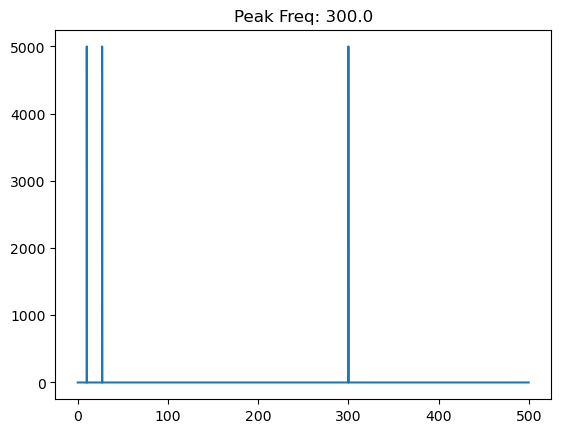

In [293]:
# FFT test
def f(x):
    return (
        np.cos(2 * np.pi * 300 * x) + 
        np.cos(2 * np.pi * 27 * x) +
        np.cos(2 * np.pi * 10 * x)
    )

def F(x):
    return fftshift(fft(x))


x = np.arange(0, 10, 1/1000)
    
output = F(f(x))

N = len(output)
freqs = fftshift(fftfreq(N, 1/1000))

midpoint = output.shape[0]//2

# positive values only
pos_freqs = freqs[midpoint:]
pos_output = output[midpoint:]

# get top 3 frequencies
ind = np.argpartition(pos_output, -3)[-3:]
print(np.abs(pos_freqs[ind]))

plt.plot(pos_freqs, np.abs(pos_output))
plt.title(f"Peak Freq: {pos_freqs[np.argmax(pos_output)]}")
plt.show()
plt.close()

### Get & Plot FFT Data

In [206]:
def get_fftdata_from_window(window: np.array, verbose=False) -> list[np.array, np.array, float]:
    """
        Performs FFT on a window/snippet
        
        :param window: sample data from a snippet
                       of a song
        :param verbose: if True, plots FFT data
        
        :return samps_fft: raw FFT output
        :return samps_freqs: array of frequencies
                             for indexing `samps_fft`
        :return fs: sampling frequency
    """
    samps = window

    t0 = 0
    t_max = get_window_length(seconds)
    fs = get_samp_per_sec(t_max, samps.shape) # try replacing with 44100

    t = np.arange(t0, t_max, 1/fs)

    samps_fft = fftshift(fft(samps))
    samps_freqs = fftshift(fftfreq(len(t), 1/fs))
    
    if verbose:
        plt.plot(samps_freqs, np.abs(samps_fft))
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.xlim(-4000, 4000)
        plt.show()
        plt.close()
    
    return samps_fft, samps_freqs, fs

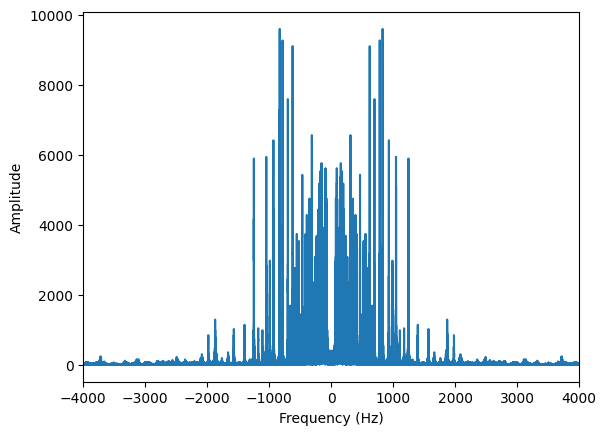

In [164]:
samps_fft, samps_freqs, fs = get_fftdata_from_window(windows[win_num], verbose=True)

In [195]:
def get_top_k_freqs(fft_data: np.array, fs: int, k: int, verbose=False) -> np.array:
    """
        Gets top k most prevalent frequencies in order of prevalence
        
        :param fft_data: output of fftshift(fft(...))
        :param fs: sampling frequency
        :param k: return value contains 
                  k maximum values
        :param verbose: if True, prints frequencies
                  
        :return: k-value array of highest
                 frequencies in fft_data
    """
    N = fft_data.shape[0]
    freqs = fftshift(fftfreq(N, 1/fs))

    # positive values only
    pos_freqs = freqs[N//2:]
    pos_fft_data = fft_data[N//2:]
    pos_fft_data = np.abs(pos_fft_data)

    # get top k frequencies
    ind = np.argpartition(pos_fft_data, -k)[-k:]
    most_prev = pos_freqs[ind]
    
    # truncate to 5 decimal places
    most_prev = np.around(most_prev, 5)
    
    if verbose:
        print(most_prev)
    
    return most_prev

In [113]:
def transpose_freq(freq: float) -> float:
    """
        Transposes frequencies to fit within one octave
        
        :param freq: frequency value

        :return: transposed frequency
                 value in octave 4
    """
    c4_freq = 261.6256
    c5_freq = 523.2511
    while not (c4_freq <= freq <= c5_freq):
        if freq > c5_freq:
            freq /= 2
        if freq < c4_freq:
            freq *= 2
            
    return freq

In [114]:
print(transpose_freq(98.12121212))

392.48484848


### Get Most Prevalent Frequencies

In [76]:
# define pitches in octave 4
pitch_to_freq_4 = {
    "C" : 261.6256,
    "C#" : 277.1826,
    "Db" : 277.1826,
    "D" : 293.6648,
    "D#" : 311.1270,
    "Eb" : 311.1270,
    "E" : 329.6276,
    "F" : 349.2282,
    "F#" : 369.9944,
    "Gb" : 369.9944,
    "G" : 391.9954,
    "G#" : 415.3047,
    "Ab" : 415.3047,
    "A" : 440.0000,
    "A#" : 466.1638,
    "Bb": 466.1638,
    "B" : 493.8833
}

freq_to_pitch_4 = {value : key for key, value in pitch_to_freq_4.items()}

In [123]:
# get k most prevalent frequencies
k = 12

# before transposing
most_prev = get_top_k_freqs(samps_fft, fs, k) # replace 44100 with fs if broken

# after transposing
# most_prev = np.array([transpose_freq(x) for x in most_prev])

print(f"Top {k} frequencies:\n{most_prev}")

Top 12 frequencies:
[138.07407407 137.37037037 104.11111111 123.18518519 104.59259259
 119.44444444 130.66666667 136.96296296 141.85185185 104.51851852
 145.59259259 138.11111111]


In [14]:
# stores pitches from C0 to A10

AFreq = 440
exponent = -5
pitchClasses = {}
# no flats/sharps between BC and EF
keys = ['A', ('A#','Bb'), 'B', 'C', ('C#','Db'), 'D', ('D#','Eb'), 'E', 'F', ('F#','Gb'), 'G', ('G#','Ab')]

while AFreq*math.pow(2,exponent) < 20000:
    freqA = AFreq*math.pow(2,exponent)
    for num in range(12):
        octave = 4+exponent
        if isinstance(keys[num], tuple):
            if keys[num][0] >= 'C':
                octave += 1
            pitchClasses.update({keys[num][0]+str(octave) : freqA*math.pow(2, num/12)})
            pitchClasses.update({keys[num][1]+str(octave) : freqA*math.pow(2, num/12)})
        else:
            if keys[num] >= 'C':
                octave += 1
            pitchClasses.update({keys[num]+str(octave) : freqA*math.pow(2, num/12)})
    exponent += 1
    
# delete pitches before octave 0
for _ in range(4):
    del pitchClasses[list(pitchClasses.keys())[0]]
    
# prints all octaves for a pitch class
print(list(pitchClasses.items())[::17])

[('C0', 16.351597831287414), ('C1', 32.70319566257483), ('C2', 65.40639132514966), ('C3', 130.8127826502993), ('C4', 261.6255653005986), ('C5', 523.2511306011972), ('C6', 1046.5022612023945), ('C7', 2093.004522404789), ('C8', 4186.009044809578), ('C9', 8372.018089619156), ('C10', 16744.036179238312)]


In [15]:
def get_octave(freq: float) -> int:
    """
        Returns octave number of given frequency
        
        :param freq: frequency value
        
        :return: octave number or None if
                 beyond octave ranges
    """
    # octave numbers of all Cs
    c_freqs = {
        0 : 16.35160,
        1 : 32.70320,
        2 : 65.40639,
        3 : 130.8128,
        4 : 261.6256,
        5 : 523.2511,
        6 : 1046.502,
        7 : 2093.005,
        8 : 4186.009,
        9 : 8372.018,
        10: 16744.04
    }
    
    for oc, fr in c_freqs.items():
        if fr > freq:
            return oc - 1
        
    return None

In [116]:
# test get_octave(...)
print(get_octave(most_prev[0]))

3


In [16]:
def get_freqs_in_class(pc: str) -> np.array:
    """
        Returns list of frequencies in given pitch class
        
        :param pc: name of pitch class
        
        :return: 11-value array of all
                 frequencies from octaves
                 0 to 10 for given pitch
    """
    pc = pc[0].upper() + pc[1:]
    return np.array([
        pitchClasses[x]
        for x in pitchClasses
        if x[:len(pc)] == pc
    ])

In [117]:
# test get_freqs_in_class(...)
print(get_freqs_in_class("c#"))

[1.73239144e+01 3.46478289e+01 6.92956577e+01 1.38591315e+02
 2.77182631e+02 5.54365262e+02 1.10873052e+03 2.21746105e+03
 4.43492210e+03 8.86984419e+03 1.77396884e+04]


In [17]:
def get_freqs_in_octave(freq: float) -> np.array:
    """
        Returns all pitches in octave of freq
        
        :param freq: frequency value
        
        :return: 17-value array of all frequencies in
                 same octave as freq
    """
    oc = get_octave(freq)
    return np.array([
        pitchClasses[x]
        for x in pitchClasses
        if ''.join(c for c in x
                   if c.isdigit()) == str(oc)
    ])

In [118]:
# test get_freqs_in_octave(...)
print(get_freqs_in_octave(most_prev[1]))

[130.81278265 138.59131549 138.59131549 146.83238396 155.56349186
 155.56349186 164.81377846 174.61411572 184.99721136 184.99721136
 195.99771799 207.65234879 207.65234879 220.         233.08188076
 233.08188076 246.94165063]


In [18]:
def broadcast_down(freq_arr: np.array) -> np.array:
    """
        Resizes array from 17 pitches to 12
        to account for enharmonicity
        
        Will NOT contain duplicates
    """
    if len(freq_arr) == 12:
        return freq_arr
    
    res = []
    visited = set()
    
    for val in freq_arr:
        if val not in visited:
            visited.add(val)
            res.append(val)
        
    return np.array(res)


def broadcast_up(freq_arr: np.array) -> np.array:
    """
        Resizes array from 12 pitches to 17
        to account for enharmonicity
        
        Will contain duplicates
        
        **DOES NOT RETAIN ORDER**
    """
    if len(freq_arr) == 17:
        return freq_arr
    
    res = np.array([None]*17)
    enharm = [1, 4, 6, 9, 11]
    extra_i = 0
    
    for i in range(12):
        if i in enharm:
            res[i+extra_i] = freq_arr[i]
            extra_i += 1
        res[i+extra_i] = freq_arr[i]
        
    return res

In [134]:
def get_closest_pitch(freq: float) -> str:
    """
        Returns closest pitch for given frequency
        
        :param freq: frequency value
        
        :return: string containing pitch
                 class and octave number
    """
    oc_freqs = get_freqs_in_octave(freq)
    if oc_freqs.size == 0:
        oc_freqs = get_freqs_in_octave(transpose_freq(freq))
        
    oc_freqs -= freq
    oc_freqs = np.abs(oc_freqs)
    ind = np.argmin(oc_freqs) # index of closest
    closest_pc = list(pitch_to_freq_4)[ind]
    closest_oc = str(get_octave(freq))
    return closest_pc + closest_oc 

In [119]:
# test get_closest_pitch(...)
print(get_closest_pitch(most_prev[0]))

C#3


### Find Closest Pitches from Given Window

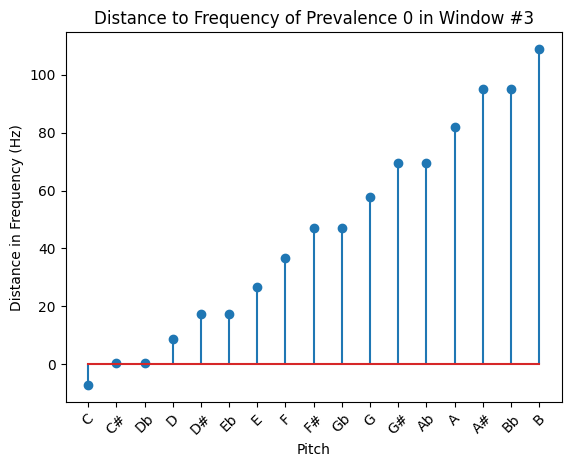

In [120]:
# print prevalence of pitches relative to prevalence number prev_num

# prevalence number; 0 is highest
prev_num = 0

# stores frequencies in scale of most_prev[prev_num]
curr_freqs = get_freqs_in_octave(most_prev[prev_num])
freqs_dist = curr_freqs - most_prev[prev_num]

ptf4 = list(pitch_to_freq_4)

plt.stem(list(ptf4), freqs_dist)
plt.xticks(rotation=45)
plt.xlabel("Pitch")
plt.ylabel("Distance in Frequency (Hz)")
plt.title(f"Distance to Frequency of Prevalence {prev_num} in Window #{win_num}")
plt.show()
plt.close()

In [166]:
def get_pitch_counts(most_prev: np.array, verbose=False) -> Counter:
    """
        Gets Counter of most prevalent pitch classes
        
        :param most_prev: NP array of most
                          prevalent pitches
                          
        :return: Counter of most prevalent
                 pitch classes
    """
    # get closest pitch for each prevalent frequency
    closest_pitches = np.array([get_closest_pitch(x) for x in most_prev])

    # remove octave number
    for i, _ in enumerate(closest_pitches):
        while not closest_pitches[i][-1].isalpha():
            closest_pitches[i] = closest_pitches[i][:-1]
            
    counter = Counter(closest_pitches)
            
    if verbose:
        pitches = [pair[0] for pair in counter.items()]
        counts = [pair[1] for pair in counter.items()]

        plt.stem(pitches, counts)
        plt.show()
        plt.close()

    return counter

In [167]:
def get_pitch_vector(most_prev: np.array, verbose=False) -> np.array:
    """
        Returns vector of pitch counts indexed
        by semitone distance to C
        
        e.g.: C -> index 0
              G -> index 7
              
        :param most_prev: NP array of most
                          prevalent pitches
                          
        :return: 12-value vector of most
                 prevalent pitch counts
                 indexed at C
    """
    pitch_vec = np.array([0]*12)
    pitch_names = ["C", "C#/Db", "D", "D#/Eb","E",
                   "F", "F#/Gb", "G", "G#/Ab", "A",
                   "A#/Bb", "B"]
    pitch_names_dict = {
        pitch_names[i] : i
        for i in range(len(pitch_names))
    }
    enharm_names_dict = {
        "C#" : 1, "Db" : 1,
        "D#" : 3, "Eb" : 3,
        "F#" : 6, "Gb" : 6,
        "G#" : 8, "Ab" : 8,
        "A#" : 10, "Bb" : 10
    }
    
    pitch_counts = get_pitch_counts(most_prev)

    for pitch in pitch_counts:
        p = pitch[0].upper() + pitch[1:]
        
        if "#" in p or "b" in p:
            ind = enharm_names_dict[p]
        else:
            ind = pitch_names_dict[p]
            
        pitch_vec[ind] += pitch_counts[pitch]
        
    if verbose:
        print(pitch_vec)
    
    return pitch_vec

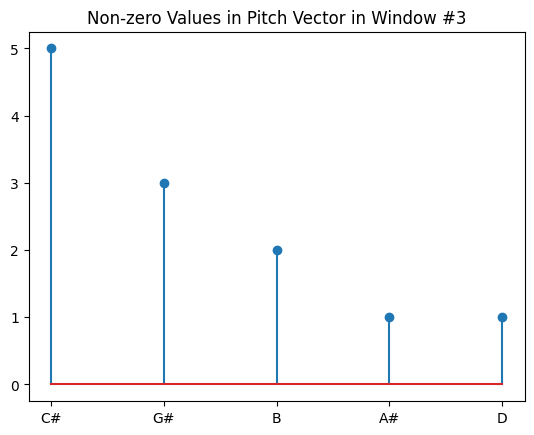

In [98]:
# get counts of most prevalent frequencies
pitch_counts = get_pitch_counts(most_prev)

pitches = [pair[0] for pair in pitch_counts.items()]
counts = [pair[1] for pair in pitch_counts.items()]

plt.stem(pitches, counts)
plt.title(f"Non-zero Values in Pitch Vector in Window #{win_num}")
plt.show()
plt.close()

In [169]:
# get pitch vector of most prevalent frequencies

# C Major pitch vector: [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
# C Minor pitch vector: [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
pv = get_pitch_vector(most_prev)
print("Pitch Vector:", pv)

# stores center of mass of indices
# weighted by count value
com = np.round(np.average(np.arange(len(pv)), weights=pv))
pvq = deque(pv)

num_semitones = int(com) + (len(pvq)//2)
print(f"Transposing up {num_semitones} semitones")
pvq.rotate(num_semitones)
print("Rotated Pitch Vector:", [float(val) for val in pvq])

Pitch Vector: [12  0  0  0  0  0  0  0  0  0  0  0]


### TODO: Fix the transposition function to center at C (index 0)

May be able to try below method with major and minor chord tones, then use return value to determine which key is most likely between parallel scales

In [80]:
def get_dist_to_C(p_vec: np.array) -> int:
    """
        Returns number of right rotations (up transpositions)
        to arrive at C
    """
    DIATONIC_WEIGHT = 1.0
    CHROMATIC_WEIGHT = 0.2

    """
    MAY BE ABLE TO OPTIMIZE
    """
    chord_weights = np.array([CHROMATIC_WEIGHT]*12)
    chord_weights[0] = 0.7*DIATONIC_WEIGHT      # root
    chord_weights[3] = DIATONIC_WEIGHT          # minor 3
    chord_weights[4] = DIATONIC_WEIGHT          # major 3
    chord_weights[7] = 0.5*DIATONIC_WEIGHT      # perfect fifth; may be omitted
    chord_weights[10] = 0.85*DIATONIC_WEIGHT    # minor 7
    chord_weights[11] = 0.85*DIATONIC_WEIGHT    # major 7

    # find shift that maximizes weight chord tones
    max_val = 0
    max_shift = 0
    for i in range(12):
        tq = deque(p_vec)
        tq.rotate(i)
        
        # emphasize chord tones
        tq *= chord_weights
        # prints shift value, weighted sum, and weighted pitch vector
        print(i, sum(tq), [float(val) for val in tq])
        
        if sum(tq) > max_val:
            max_val = sum(tq)
            max_shift = i
            
    return max_shift

In [204]:
def get_dist_to_C_with_quality(p_vec: np.array, verbose=False) -> int:
    """
        Returns number of semitones to shift DOWN
        (rotate) to make most likely root index 0
        
        Checks both C major and minor and returns based on
        most likely result
        
        :return: tuple containing semitone shift
                 value to get to C and `quality`
                 
                 if major, `quality` = True
    """
    DIATONIC_WEIGHT = 1.0
    CHROMATIC_WEIGHT = 0.01
    
    pitch_names = ["C", "C#/Db", "D", "D#/Eb","E",
                   "F", "F#/Gb", "G", "G#/Ab", "A",
                   "A#/Bb", "B"]

    # initialize weights of chord tones
    major_chord_weights = np.array([CHROMATIC_WEIGHT]*12)
    minor_chord_weights = np.array([CHROMATIC_WEIGHT]*12)
    
    # roots
    major_chord_weights[0] = 0.65*DIATONIC_WEIGHT
    minor_chord_weights[0] = 0.65*DIATONIC_WEIGHT
    
    # perfect fifths
    major_chord_weights[7] = 0.5*DIATONIC_WEIGHT
    minor_chord_weights[7] = 0.5*DIATONIC_WEIGHT
    
    # thirds
    minor_chord_weights[3] = DIATONIC_WEIGHT          # minor 3
    major_chord_weights[4] = DIATONIC_WEIGHT          # major 3
    
    # ----- Upper Chord Extensions -----
    
    # chord sevenths
    minor_chord_weights[10] = 0.7*DIATONIC_WEIGHT    # minor 7
    major_chord_weights[11] = 0.7*DIATONIC_WEIGHT    # major 7
    
    # chord ninths
    minor_chord_weights[2] = 0.3*DIATONIC_WEIGHT
    major_chord_weights[2] = 0.3*DIATONIC_WEIGHT
    
    # ----- Tendency Tones -----
    
    major_chord_weights[5] = 0.2*DIATONIC_WEIGHT    # 4 -> 3
    minor_chord_weights[8] = 0.2*DIATONIC_WEIGHT    # 6 -> 5
    

    # find shift that maximizes weight chord tones
    quality = True
    max_val = 0
    shift = 0
    
    if verbose:
        print("Pitch Vector:", [float(val) for val in p_vec])
    
    # check both major and minor modes
    for chord_weights in [major_chord_weights, minor_chord_weights]:
        isMajor = all(np.equal(chord_weights, major_chord_weights))
        
        if verbose:
            print("Major" if isMajor else "Minor")
            print("Chord Weights:", [float(val) for val in chord_weights])
            print("Pitch Vector (No Rotation):", [float(val) for val in p_vec])
        
        for i in range(12):
            # rolling by POSITIVE value transposes DOWN
            pv = np.roll(p_vec, i)
            
            # emphasize chord tones
            pv = np.multiply(pv, chord_weights)
            
            # prints shift value, weighted sum, and weighted pitch vector
            if verbose:
                key = pitch_names[-i]
                print(f"{key}\t{np.round(np.sum(pv), 3)}\t{[round(float(val), 5) for val in pv]}")
            
            if np.sum(pv) > max_val:
                max_val = np.sum(pv)
                
                quality = isMajor
                shift = i
            
    # return semitones to shift 
    return shift, quality

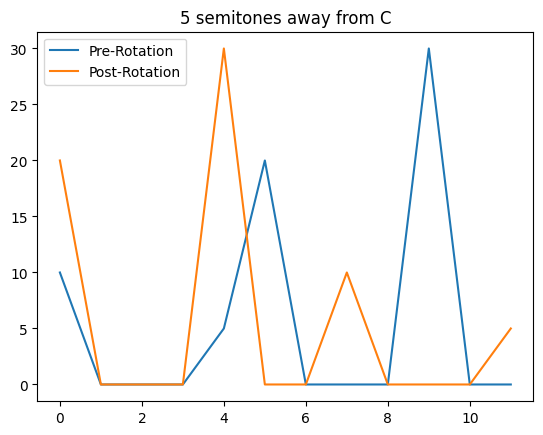

In [84]:
# test get_dist_to_C(...) and get_dist_to_C_with_quality(...)

# C major 7 chord, emphasized 3
test_arr = np.array([20, 0, 0, 0, 30, 0, 0, 10, 0, 0, 0, 5]).astype(np.float32)

test_arr = np.roll(test_arr, 5)

test_shift, quality = get_dist_to_C_with_quality(test_arr)

test_q = deque(test_arr)
test_q.rotate(test_shift)

plt.plot(test_arr, label="Pre-Rotation")
plt.plot(test_q, label="Post-Rotation")
plt.title(f"{12-test_shift} semitones away from C")
plt.legend()
plt.show()
plt.close()

In [26]:
def get_scale_from_vector(p_vec: list) -> str:
    """
        Return name of most likely scale
        given vector of most prevalent pitches
        
        :param p_vec: 12-value pitch vector
        
        :return: name of scale
    """
    # stores semitones to be transposed to get to C
    # less emphasis on 2, 4, and 5
    c_major = [1, 0, 0.6, 0, 1, 0.7, 0, 0.4, 0, 1, 0, 1]
    c_minor = [1, 0, 0.6, 1, 0, 0.7, 0, 0.4, 1, 0, 1, 0]
    pitch_names = ["C", "C#/Db", "D", "D#/Eb","E",
                   "F", "F#/Gb", "G", "G#/Ab", "A",
                   "A#/Bb", "B"]
    
    c_major = np.array(c_major)
    c_minor = np.array(c_minor)
    
    # ----- NOT IN USE -----
    # # center of mass of indices
    # # weighted by count value
    # com = np.round(
    #     np.average(np.arange(len(p_vec)),
    #     weights=p_vec)
    # )
    # pvq = deque(p_vec)
    
    # semitones = int(com) + (len(pvq)//2) # what is this for?
    # pvq.rotate(semitones)
    
    # pv = np.array(pvq)
    # ----- NOT IN USE -----
    
    semitones, quality = get_dist_to_C_with_quality(p_vec)
    key = pitch_names[semitones]
    # print("[get_scale_from_vector]", semitones, key)
    
    pv = deque(p_vec)
    pv.rotate(semitones)
    
    # Euclidean distance to major or minor
    major_dist = np.linalg.norm(np.abs(pv-c_major))
    minor_dist = np.linalg.norm(np.abs(pv-c_minor))
    
    quality = "Major"
    if major_dist > minor_dist:
        quality = "Minor"
    
    return pitch_names[-semitones%12] + " " + quality

In [150]:
# test get_scale_from_vector(...)
pv = get_pitch_vector(most_prev)
print(get_scale_from_vector(pv))

[get_pitch_counts] ['C-1' 'C-1' 'C-1' 'C-1' 'C-1' 'C-1' 'C-1' 'C-1' 'C-1' 'C-1' 'C-1' 'C-1']
[get_pitch_vector] Counter({np.str_('C'): 12})
C Major


In [126]:
# test get_dist_to_C_with_quality(...)
pitch_names = ["C", "C#/Db", "D", "D#/Eb","E",
                "F", "F#/Gb", "G", "G#/Ab", "A",
                "A#/Bb", "B"]

smtns, qlty = get_dist_to_C_with_quality(pv, verbose=False)

# smtns should be 2

print(np.roll(pv, smtns))
print("Semitones to shift DOWN:", smtns)
print(pitch_names[-smtns], ("Major" if qlty else "Minor"))

[2 0 0 2 1 3 1 0 0 0 3 0]
Semitones to shift DOWN: 4
G#/Ab Minor


## Use collected data to choose most likely scale

In [205]:
ind = list(instrumental_data.keys())[0]
print(ind)

# samples of audio data
# length of song in seconds
samples, seconds = instrumental_data[ind]

print(f"{seconds} Seconds Long")

# list of snippets in song
# start time in seconds of each snippet
windows, start_times = create_snippets(samples, seconds)

song_pv = np.array([0.0]*12)

for i, window in enumerate(windows):
    print(f"Window Start Time: {int(start_times[i]//60)} m {start_times[i]%60:.2f} s")
    
    # Raw FFT data
    # FFT frequencies for indexing
    # Sampling frequency
    samps_fft, samps_freqs, fs = get_fftdata_from_window(window)
    
    # Top 12 most prevalent frequencies
    most_prev = get_top_k_freqs(samps_fft, fs, k=12, verbose=True)
    
    # 12-valued pitch vector
    pv = get_pitch_vector(most_prev, verbose=True)
    song_pv += pv
    

# semitones required to shift DOWN to get to C
# quality of song; True if major
shift, isMajor = get_dist_to_C_with_quality(song_pv, verbose=True)
    
print(pitch_names[-shift], ("Major" if isMajor else "Minor"))

bee gees_how deep is your love_f minor_105
260.25 Seconds Long
Window Start Time: 0 m 0.00 s
[232.75     77.59375  77.6875   77.4375   77.40625 310.71875 310.90625
 310.875   310.8125  310.78125 310.84375 310.75   ]
[ 0  0 11  0  0  0  0  0  0  1  0  0]
Window Start Time: 0 m 16.00 s
[310.8125  311.03125 414.84375  77.84375 349.      310.90625 414.9375
 310.875   232.75    310.84375 310.75    310.78125]
[0 0 8 0 0 1 0 2 0 1 0 0]
Window Start Time: 0 m 32.00 s
[310.84375  70.       45.5     175.      391.4375  414.96875  63.
  87.5      42.       59.5      38.5     349.09375]
[1 0 2 0 1 4 0 2 0 1 0 1]
Window Start Time: 0 m 48.00 s
[391.65625 310.6875  349.125   310.75    311.0625  310.71875 155.40625
 155.4375  310.8125  391.53125 310.65625 310.625  ]
[0 0 9 0 0 1 0 2 0 0 0 0]
Window Start Time: 1 m 4.00 s
[155.40625 391.9375  391.53125 310.71875 310.78125 311.03125 310.625
 391.625   391.5625  310.65625 155.4375  310.6875 ]
[0 0 8 0 0 0 0 4 0 0 0 0]
Window Start Time: 1 m 20.00 s
[415